First, load the data,in this notebook we are using the GEM data from Ashley's github

In [1]:
import sys
sys.path.append('./Code')
import loadData 
import RunML
import RunML_continue
import FS

import pandas as pd
import numpy as np
import random
import time
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.linear_model import LogisticRegression
#from sklearn import svm


In [2]:
import tarfile
from io import StringIO
import chardet

### read the 3 files

In [3]:
# Path to the .tar.gz file
GEM_path = './Data/GEM_files.tar.gz'

# Open the tar.gz file
with tarfile.open(GEM_path, 'r:gz') as tar:
    # List all files in the tar archive
    for member in tar.getmembers():
        print(member.name)

annotation_features_counts_wide.tsv
pathway_features_counts_wide.tsv
GEM_metadata.tsv
ReadMe.txt


In [4]:
metadata = pd.read_csv('../Bigdatafolder/GEM_files/GEM_metadata.tsv',delimiter='\t')

In [5]:
print(metadata)

            genome_id  genome_length  completeness    domain          phylum  \
0       3300007803_15        1278095         65.83  Bacteria    Firmicutes_C   
1       3300007803_10        1557142         54.52  Bacteria    Bacteroidota   
2        3300007803_5        1979162         94.54  Bacteria      Firmicutes   
3        3300007803_3        2482248         89.71  Bacteria    Bacteroidota   
4        3300026873_1        3255966         82.05  Bacteria  Proteobacteria   
...               ...            ...           ...       ...             ...   
52510    3300027714_8        2962332         97.46       NaN             NaN   
52511   3300020373_65         769333         71.36       NaN             NaN   
52512  3300009095_122        2049267         95.15       NaN             NaN   
52513   3300025681_61         453020         65.42       NaN             NaN   
52514   3300026256_22        1548234         62.13       NaN             NaN   

                     class             

In [6]:
metadata.shape

(52515, 13)

In [7]:
metadata[metadata['domain'].isna()]['cultured.status'].value_counts()

cultured.status
uncultured    10
Name: count, dtype: int64

In [8]:
metadata[metadata['domain'].notna()]['cultured.status'].value_counts()

cultured.status
uncultured    42700
cultured       9805
Name: count, dtype: int64

In [9]:
pathwaydata = pd.read_csv('../Bigdatafolder/GEM_files/pathway_features_counts_wide.tsv',delimiter='\t')

In [10]:
pathwaydata.shape

(52515, 71)

In [11]:
print(pathwaydata)

          genome_id  16S rRNA modification  23S rRNA modification  \
0      2004178001_1                      9                      6   
1      2009439000_2                      4                      2   
2      2010170002_1                     10                      3   
3      2012990006_1                      5                      1   
4      2013515001_1                      3                      1   
...             ...                    ...                    ...   
52510  3300029947_6                      8                      9   
52511  3300029947_7                      9                     10   
52512  3300029947_9                     10                      8   
52513  3300029948_2                     12                      6   
52514  3300029948_3                      8                      5   

       Aminoacyl-tRNA synthetases  Arginine biosynthesis  \
0                              34                     46   
1                              20                  

In [12]:
#annotationdata = pd.read_csv('../Bigdatafolder/GEM_files/annotation_features_counts_wide.tsv',delimiter='\t')

In [13]:
"""
# Read the file in binary mode
with open('../Bigdatafolder/GEM_files/annotation_features_counts_wide.tsv', 'rb') as file:
    raw_data = file.read()
    result = chardet.detect(raw_data)
    encoding = result['encoding']

print(f"Detected encoding: {encoding}")
"""

'\n# Read the file in binary mode\nwith open(\'../Bigdatafolder/GEM_files/annotation_features_counts_wide.tsv\', \'rb\') as file:\n    raw_data = file.read()\n    result = chardet.detect(raw_data)\n    encoding = result[\'encoding\']\n\nprint(f"Detected encoding: {encoding}")\n'

In [14]:
is_same = set(metadata['genome_id']) == set(pathwaydata['genome_id'])
print(is_same)

True


In [15]:
mergeds_df = pd.merge(metadata, pathwaydata, on='genome_id')
mergeds_df.set_index('genome_id', inplace=True)

In [16]:
mergeds_df.shape
ASV = list(mergeds_df.columns)

In [17]:
label1 = metadata['cultured.status']

In [18]:
label1

0          cultured
1          cultured
2          cultured
3          cultured
4          cultured
            ...    
52510    uncultured
52511    uncultured
52512    uncultured
52513    uncultured
52514    uncultured
Name: cultured.status, Length: 52515, dtype: object

In [19]:
data = pathwaydata.copy()# use pathway as data since metadata is  not numeric

In [20]:
data.set_index('genome_id', inplace=True)
ASV= list(data.columns)

In [21]:
data=RunML.normalizingMatrixToRanks(data,cutOff=0.01)
print(np.shape(data))

(52515, 70)


Perform multiLabel feature selection, this is done by calculating Kruskal-Wallis H-test on each OTU for each environmental factor, each OTU/ASV is given a weighted h score.

In [22]:
yList=[list(label1)]

In [23]:
weights=FS.multiLabelFeatureWeighting(data,yList)

In [24]:
len(weights)

70

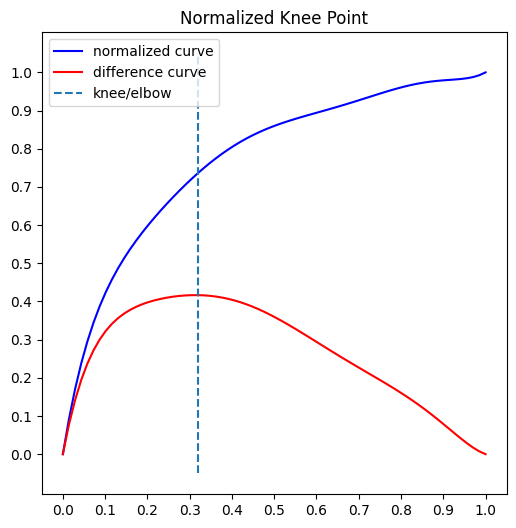

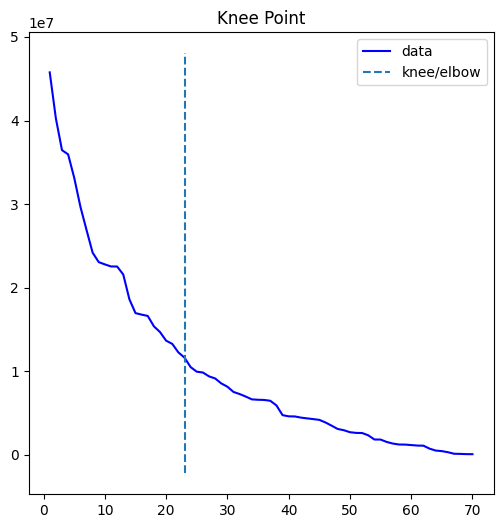

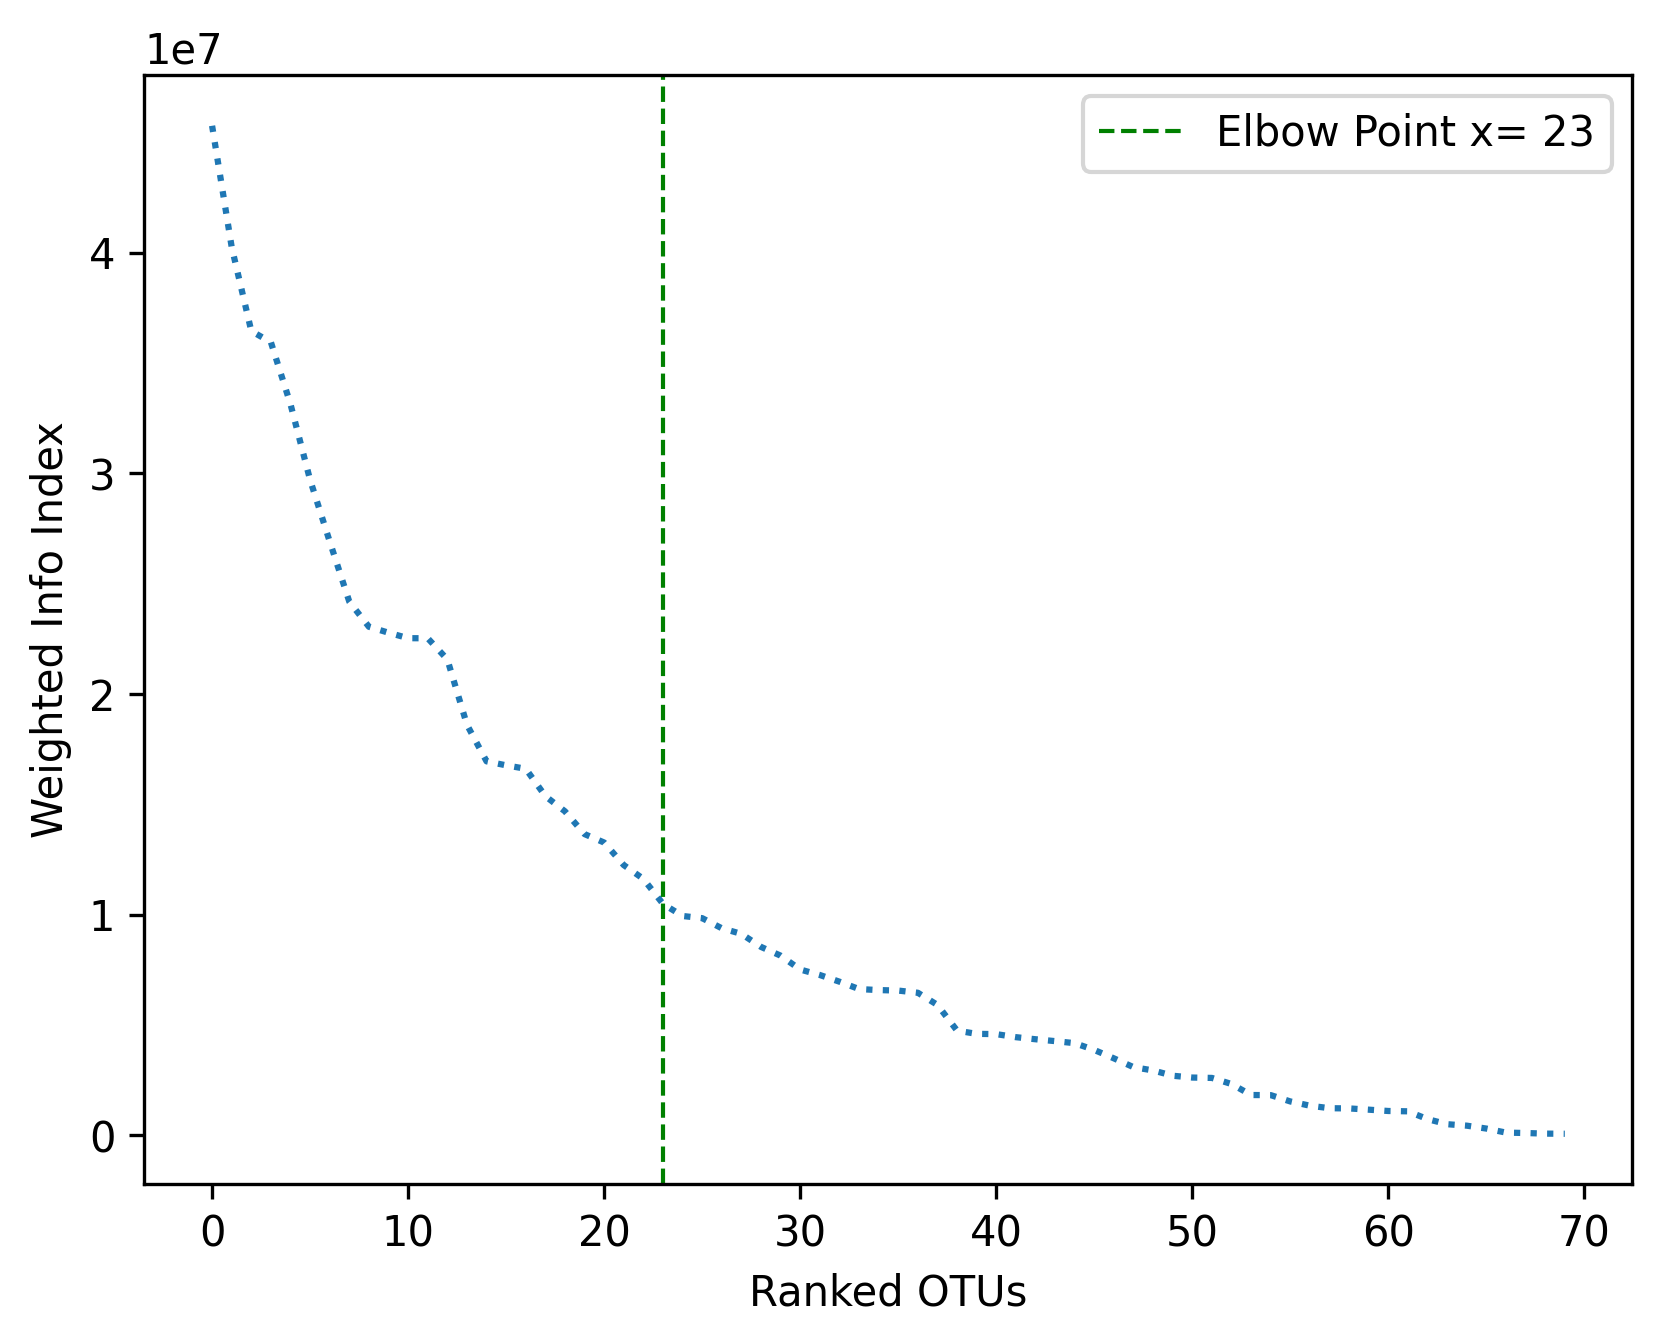

In [25]:
scores=(sorted(weights,reverse=True))
eps=FS.elbowPoint(scores)
FS.plotWeightedIndex(weights,xKnee=eps)


This plot shows that the gain in information decreases as we include more OTUs along the ranks. 

In [26]:
topFeature_selected=eps
print(eps)

X_FS,selectedOTU_index=FS.feature_select(data,yList,topFeature=topFeature_selected)
print (np.shape(X_FS))


23
(52515, 23)


In [27]:
print(len(weights))

70


In [28]:
targetLabel=label1 
X_lasso = RunML.LassoFeatureSelection(data,targetLabel)
iter =5

In [29]:
data_subset = {"AllFeatures":data, 
               "SelectMicro": X_FS,
               "Lasso":X_lasso,
               "Random":data
              }
cls = ["RF","SVM"]

In [ ]:
start_time = time.time()
dict_cm = RunML_continue.runClassifier_FScompare(data_subsets= data_subset,y= targetLabel,N=iter,classifiers=cls)
end_time = time.time()
print(f"It took {end_time - start_time:.2f} seconds")

In [ ]:
import pickle

# Save dictionary to a pickle file
with open('results/dict_cm_GEM.pkl', 'wb') as pickle_file:
    pickle.dump(dict_cm, pickle_file)

In [ ]:
import pickle
# Load dictionary from the pickle file
with open('results/dict_cm_GEM.pkl.pkl', 'rb') as pickle_file:
    data_loaded = pickle.load(pickle_file)

In [ ]:
for dataset_name, classifiers in data_loaded.items():
        for classifier_name, labels in classifiers.items():
            actual_labels = labels[0]
            predicted_labels = labels[1]
            RunML_continue.plotmacro_confusion_matrices(actual_labels, predicted_labels,f"{dataset_name} - {classifier_name}")

### on urban and Natural factor

In [ ]:
clf=RandomForestClassifier(random_state=0)
targetLabel=label1                             

In [ ]:
# plot for random forest for all features and SelectMicro
RunML.CrossFoldValidation_AUC(data,targetLabel,title="AUC (No Feature Selection)",classifier=clf)
RunML.CrossFoldValidation_AUC(X_FS,targetLabel,title=f'AUC (Top {eps} Features)',classifier=clf)
  

In [ ]:
## plot for SVM for all features and SelectMicro
RunML.CrossFoldValidation_AUC(data,targetLabel,title="AUC (No Feature Selection)")
RunML.CrossFoldValidation_AUC(X_FS,targetLabel,title=f'AUC (Top {eps} Features)')

In [ ]:
randomFeatures=random.sample(list(range(np.shape(data)[1])), topFeature_selected)
X_randomFeatures=np.array(data)[:,randomFeatures]
RunML.CrossFoldValidation_AUC(X_randomFeatures,targetLabel,title="AUC (318 Random Features)",classifier=clf)
RunML.CrossFoldValidation_AUC(X_randomFeatures,targetLabel,title="AUC (318 Random Features)")

In [ ]:
# random forest and SVM result for lasso selection: 
#for now, only the random forest AUC value is same with the value in table 1 which I calculated  using functions.
X_Lasso=RunML.LassoFeatureSelection(data,targetLabel)
RunML.CrossFoldValidation_AUC(X_Lasso,targetLabel,title="AUC (LASSO)",classifier=clf)

In [ ]:
RunML.CrossFoldValidation_AUC(X_Lasso,targetLabel,title="AUC (LASSO)")

## Confusion matrix using RF

In [ ]:
clf=RandomForestClassifier(random_state=0)

In [ ]:
cat=["Low","High"] 
RunML.classificationHeatMap(data,targetLabel,cat,classifier=clf,title="")
RunML.classificationHeatMap(X_FS,targetLabel,cat,classifier=clf,title="")

## compare the first 15 index

In [ ]:

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

entries=15
selectedOTU_index_15=selectedOTU_index[:entries]
X_FS_15=data[:,selectedOTU_index_15]

df=pd.DataFrame(data=X_FS_15)
selectedASVs=[ASV[i] for i in selectedOTU_index_15]

print(set(targetLabel))


In [ ]:
RunML.plotPresenseRatio(X_FS_15,targetLabel,selectedASVs,posLabel="LO30",posText="Low",negText="High",entries=entries)
